# Using EQLM

This notebook provides an example of using the EQLM module and shows how data was collected for the publication.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture 
#used to discard the output of tensorflow warnings
import EQLM

In [3]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy.ndimage import uniform_filter1d

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [4]:
class CartPoleHeuristic(object):
    """Heuristic action selection used for the CartPole environment"""
    step_no = 0
    def action(self,*args):
        self.step_no += 1
        return self.step_no%2

## Training an Agent in an Environment

EQLM uses a wrapper class for the OpenAI gym environments. The default environment is 'CartPole-v0'.

In [5]:
env = EQLM.Environment()
agent = EQLM.QAgent(env, net_type='ELMNet', f_heur=CartPoleHeuristic().action, n_heur=5,
                    gamma=0.9, eps_i=0.6, n_eps=360,
                    gamma_reg=2e-5, N_hid=25, minibatch_size=2)

Use the method 'train_agent' to train the agent on the environment.

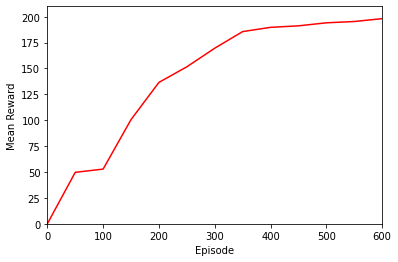

In [6]:
N_ep = 600
R, step, agent = EQLM.train_agent(agent,env,N_ep,show_progress=True)

x,R_s = EQLM.data_smooth(R,50)

fig = plt.figure()
plt.plot(x,R_s,'r')
_ = plt.xlabel('Episode')
_ = plt.ylabel('Mean Reward')
_ = plt.xlim([0,600])
_ = plt.ylim([0,210])

## Running EQLM and Standard Q-Network

In [ ]:
params_EQLM = {'gamma_reg':1.827e-5, 
               'N_hid':25, 
               'eps_i':0.559, 
               'n_eps':360, 
               'gamma':0.93, 
               'minibatch_size':2, 
               'target_updates':48, 
               'f_heur':CartPoleHeuristic().action, 
               'n_heur':5, 
               'memory_size':10000}

params_QNet = {'alpha':0.0065, 
               'N_hid':29, 
               'eps_i':0.67, 
               'n_eps':400, 
               'gamma':0.99, 
               'minibatch_size':26, 
               'target_updates':70,
               'clip_norm':1.0,
               'f_heur':CartPoleHeuristic().action, 
               'n_heur':5, 
               'memory_size':10000}

Standard Q-Network

In [ ]:
fname = time.strftime('qnet_runs_%d_%m')
N_ep = 600
N_run = 50 

t_run = trange(N_run, desc='bar_desc', leave=True)
t_run.set_description('Run 0... ')
t_run.refresh()

for run_no in t_run:
    env = EQLM.Environment()
    agent = EQLM.QAgent(env, net_type='QNet', **params_QNet)

    R, _, agent = EQLM.train_agent(agent, env, N_ep)
    t_run.set_description('Last R: ' + repr(np.mean(R[-10:])))
    t_run.refresh()
    
    EQLM.save_results(fname,R,agent,hyper_params=params_QNet)
    del agent

EQLM network

In [ ]:
fname = time.strftime('eqlm_runs_%d_%m')
N_ep = 600
N_run = 50

t_run = trange(N_run, desc='bar_desc', leave=True)
t_run.set_description('Run 0... ')
t_run.refresh()

for run_no in t_run:
    env = EQLM.Environment()
    agent = EQLM.QAgent(env, net_type='ELMNet', **params_EQLM)

    R, _, agent = EQLM.train_agent(agent, env, N_ep)
    t_run.set_description('Last R: ' + repr(np.mean(R[-10:])))
    t_run.refresh()
    
    EQLM.save_results(fname,R,agent,hyper_params=params_QNet)
    del agent

## Plot Results and Compare Performance

Data used in the publication are provided with the module

In [7]:
def ci_95(R):
    R = np.array(R)
    r_bs = [bs.bootstrap(np.array(R[:,i]), stat_func=bs_stats.mean) for i in tqdm(range(np.shape(R)[1]))]
    r_mean = [r.value for r in r_bs]
    r_lb = [r.lower_bound for r in r_bs]
    r_ub = [r.upper_bound for r in r_bs]
    return r_lb, r_mean, r_ub

def plots_side(R,R_ci,N_avg=50,N_filt=20,axis_font={'size':16}):
    fig = plt.figure(figsize=(15,6))
    
    ax = plt.subplot(1,2,1)
    for R_ep in R:
        x,r_plot = EQLM.data_smooth(R_ep,N_avg)
        ax.plot(x,r_plot)
    ax.grid()
    _ = plt.xlim([0,600])
    _ = plt.ylim([0,210])
    
    ax = plt.subplot(1,2,2)
    R_ci = uniform_filter1d(R_ci,N_filt)
    x = np.arange(len(r_ci_qnet[1]))
    ax.plot(R_ci[1],'r')
    ax.fill_between(x,R_ci[2],R_ci[0],facecolor='r',alpha=0.25)
    ax.grid()
    _ = plt.xlim([0,600])
    _ = plt.ylim([0,210])
    return fig

In [8]:
data_qnet = pickle.load(open('QNetCartpoleResults','rb'))
r_ci_qnet = ci_95(data_qnet['R'])

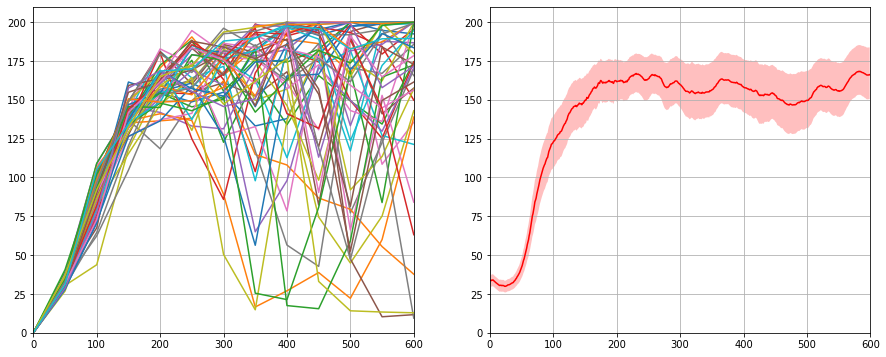

In [9]:
_=plots_side(data_qnet['R'],r_ci_qnet)

In [10]:
data_eqlm = pickle.load(open('EQLMCartpoleResults','rb'))
r_ci_eqlm = ci_95(data_eqlm['R'])

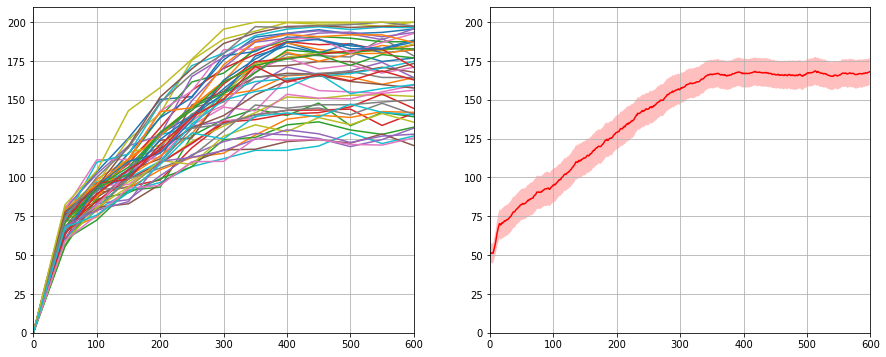

In [11]:
_=plots_side(data_eqlm['R'],r_ci_eqlm)

Run bootstrap confidence intervals on results

In [12]:
mean_r_end = lambda R: [np.mean(r[-100:]) for r in R]
auc = lambda R: [np.trapz(r) for r in R]

mean_bs = lambda v: bs.bootstrap(np.array(v), stat_func=bs_stats.mean)._apply(2,round)
std_bs = lambda v: bs.bootstrap(np.array(v), stat_func=bs_stats.std)._apply(2,round)

In [13]:
print('QNet\n----')
print('R end')
print('    Mean ' + str(mean_bs(mean_r_end(data_qnet['R']))) + '    std ' + str(std_bs(mean_r_end(data_qnet['R']))))
print('AUC')
print('    Mean ' + str(mean_bs(auc(data_qnet['R']))) + '    std ' + str(std_bs(auc(data_qnet['R']))))

print('\n')
print('EQLM\n----')
print('R end')
print('    Mean ' + str(mean_bs(mean_r_end(data_eqlm['R']))) + '    std ' + str(std_bs(mean_r_end(data_eqlm['R']))))
print('AUC')
print('    Mean ' + str(mean_bs(auc(data_eqlm['R']))) + '    std ' + str(std_bs(auc(data_eqlm['R']))))

QNet
----
R end
    Mean 160.03    (147.78, 173.37)    std 47.0    (35.09, 62.02)
AUC
    Mean 84060.3    (81034.46, 87531.73)    std 11716.87    (9209.1, 14724.81)


EQLM
----
R end
    Mean 166.86    (160.52, 173.35)    std 23.08    (20.41, 26.6)
AUC
    Mean 83300.5    (80428.44, 86211.49)    std 10648.93    (9308.33, 12380.44)
